In [1]:
#!/usr/bin/env python

# PDF-Changes.ipynb

In [2]:
'''File name: PDF-Changes.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 16.10.2021
    Date last modified: 16.10.2021

    ############################################################## 
    Purpos:

    - Calculate trends in percentile bins over 40-year period
    
    NEEDS DATA FROM:
    papers/2021_Hist-Ext-PR-Changes/programs/WRF_Preprocessor/WRF-at-COOP_PR.ipynb
    papers/2021_Hist-Ext-PR-Changes/programs/COOP_Station_preprocessor/COOP_Station_preprocessor.ipynb

'''

'File name: PDF-Changes.ipynb\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 16.10.2021\n    Date last modified: 16.10.2021\n\n    ############################################################## \n    Purpos:\n\n    - Calculate trends in percentile bins over 40-year period\n    \n    NEEDS DATA FROM:\n    papers/2021_Hist-Ext-PR-Changes/programs/WRF_Preprocessor/WRF-at-COOP_PR.ipynb\n    papers/2021_Hist-Ext-PR-Changes/programs/COOP_Station_preprocessor/COOP_Station_preprocessor.ipynb\n\n'

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import pandas as pd
import datetime
import sys 
import shapefile as shp
import matplotlib.path as mplPath
from scipy.stats import norm
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from calendar import monthrange
from tqdm import tqdm


import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cf

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

def deiscretice_timeseries(DATA,
                          bucked_size):
#     Discrete_timeseries = np.copy(DATA); Discrete_timeseries[:] = np.nan
#     for tt in range(len(DATA)):
#         if ~np.isnan(DATA[tt]) == True:   
#             INT, REST = divmod(DATA[tt], bucked_size)
#             Discrete_timeseries[tt] = INT * bucked_size
#             if tt != len(DATA)-1:
#                 DATA[tt+1] = DATA[tt+1]+REST
#     return Discrete_timeseries

    if len(DATA.shape) == 1:
        # make data 2D
        DATA = DATA[:,None]
    Discrete_timeseries = np.copy(DATA); Discrete_timeseries[:] = np.nan
    for tt in tqdm(range(DATA.shape[0])):
        INT, REST = np.apply_along_axis(np.divmod, 0, DATA[tt,:], bucked_size)
        FIN = ~np.isnan(INT)
        Discrete_timeseries[tt,:] = INT * bucked_size
        if tt != len(DATA)-1:
            DATA[tt+1,FIN] = DATA[tt+1,FIN]+REST[FIN]
    return Discrete_timeseries

In [4]:
# ================================
# BUKOFSKY REGION
# Add the subregions
import geopandas as gpd
from tqdm import tqdm

REGIONS = [ 'Appalachia.shp',
            'CPlains.shp',
            'DeepSouth.shp',
            'GreatBasin.shp',
            'GreatLakes.shp',
            'Mezquital.shp',
            'MidAtlantic.shp',
            'NorthAtlantic.shp',
            'NPlains.shp',
            'NRockies.shp',
            'PacificNW.shp',
            'PacificSW.shp',
            'Prairie.shp',
            'Southeast.shp',
            'Southwest.shp',
            'SPlains.shp',
            'SRockies.shp']

REGIONS_names = [ 'Appalachia',
            'Central Plains',
            'Deep South',
            'Great Basin',
            'Great Lakes',
            'Mezquital',
            'Mid-Atlantic',
            'North-Atlantic',
            'Northern Plains',
            'Northern Rockies',
            'Pacific Northwest',
            'Pacific Southwest',
            'Prairie',
            'Southeast',
            'Southwest',
            'Southern Plains',
            'Southern Rockies']

sel_month = [5,6,7,8,9,10]

In [5]:
##############################################################
#                READ CONUS404 CONSTANT FIELDS
sLon='XLONG_M'
sLat='XLAT_M'
sOro='HGT_M'
sLSM='LANDMASK'
sPlotDir = ''
GEO_EM_D1 = '/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'

ncid=Dataset(GEO_EM_D1, mode='r') # open the netcdf
Lon4=np.squeeze(ncid.variables[sLon][:])
Lat4=np.squeeze(ncid.variables[sLat][:])
Height4=np.squeeze(ncid.variables[sOro][:])
LSM4=np.squeeze(ncid.variables[sLSM][:])
ncid.close()


### Load COOP data

In [6]:
# This data comes from - papers/2021_Hist-Ext-PR-Changes/programs/COOP_Station_preprocessor/COOP_Station_preprocessor.ipynb

COOPsave = '/glade/campaign/mmm/c3we/prein/Papers/2021_Hist-Ext-PR-Changes/data/CCOP_stations_1979-2020.npz'
DATA = np.load(COOPsave, allow_pickle=True)
LonSTCO=DATA['LonSTCO']
LatSTCO=DATA['LatSTCO']
AltSTCO=DATA['AltSTCO']
DATA_st = DATA['CO_DATA']
RatioMissing=DATA['RatioMissing']
TimeHHCO=pd.to_datetime(DATA['TimeHH'])

MinComplDec = 0.7
MinComplRec = 0.8
iSelect = (np.min(RatioMissing, axis=0) >= MinComplDec) & (np.mean(RatioMissing, axis=0) >= MinComplRec) & (LatSTCO > 20) & (LonSTCO > -140)
print(np.sum(iSelect))

bucked_size = 2.94377397 # coarsest intervals in which pr is meassured

684


In [7]:
## remove 1979 and 2020 from time vector
FocusHours = (TimeHHCO.year > 1979) & (TimeHHCO.year < 2020) & np.isin(TimeHHCO.month, sel_month)
TimeHH = TimeHHCO[FocusHours]

### Load WRF data at COOP Stations

In [8]:
# This data comes from - papers/2021_Hist-Ext-PR-Changes/programs/WRF_Preprocessor/WRF-at-COOP_PR.ipynb
WRF_data = '/glade/campaign/mmm/c3we/prein/Papers/2021_Hist-Ext-PR-Changes/data/WRF/'
DATA_wrf = np.zeros((len(TimeHHCO),len(LonSTCO))); DATA_wrf[:] = np.nan
rgdTimeFULLMM=pd.date_range(TimeHHCO[0], end=TimeHHCO[-1], freq='m')
for mm in tqdm(range(len(rgdTimeFULLMM))):
    iTIME = (rgdTimeFULLMM[mm].month == TimeHHCO.month) & (rgdTimeFULLMM[mm].year == TimeHHCO.year)
    try:
        DATA = np.load(WRF_data+'WRF-PR-at-COOP_'+str(rgdTimeFULLMM[mm].year)+str(rgdTimeFULLMM[mm].month).zfill(2)+'_closest-GC.npz')
        DATA_wrf[iTIME,:]=DATA['WRF_stationPR']
    except:
        continue

100%|██████████| 492/492 [01:02<00:00,  7.92it/s]


### Load Stage-IV data at COOP Stations

In [9]:
# This data comes from - papers/2021_Hist-Ext-PR-Changes/programs/stage-IV_Preprocessor/Stage-IV-at-COOP_PR.ipynb
ST4_data = '/glade/campaign/mmm/c3we/prein/Papers/2021_Hist-Ext-PR-Changes/data/stage-IV/'
DATA_ST4 = np.zeros((len(TimeHHCO),len(LonSTCO))); DATA_ST4[:] = np.nan
rgdTimeFULLMM=pd.date_range(TimeHHCO[0], end=TimeHHCO[-1], freq='m')
for mm in tqdm(range(len(rgdTimeFULLMM))):
    iTIME = (rgdTimeFULLMM[mm].month == TimeHHCO.month) & (rgdTimeFULLMM[mm].year == TimeHHCO.year)
    try:
        DATA = np.load(ST4_data+'stage-IV-PR-at-COOP_'+str(rgdTimeFULLMM[mm].year)+str(rgdTimeFULLMM[mm].month).zfill(2)+'_closest-GC.npz')
        DATA_ST4[iTIME,:]=DATA['stage_IV_stationPR']
    except:
        continue
DATA_ST4[DATA_ST4>1000] = np.nan

100%|██████████| 492/492 [00:48<00:00, 10.11it/s]
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


In [10]:
# Prepare the data for easier processing
DATA_all = np.append(DATA_st[:,:,None], DATA_wrf[:,:,None], axis=2)
DATA_all = np.append(DATA_all,DATA_ST4[:,:,None], axis=2)
DATA_all = DATA_all[:,iSelect,:]
LonAll=LonSTCO[iSelect]
LatAll=LatSTCO[iSelect]

In [11]:
DATA_all = DATA_all[FocusHours,:]

In [12]:
# QC the COOP station extreme values
Nr_Events = 200 # top N events to control
ValidHours = 24 # hours before the event that should be valid
WetHours = 2 # wet hours in +- 3 hour period
for st in tqdm(range(DATA_all.shape[1])):
    rgiSort = np.argsort(DATA_all[:,st,0])
    NAN = np.isnan(DATA_all[rgiSort,st,0])
    rgiSort = np.append(rgiSort[NAN == True],rgiSort[NAN == False])[-Nr_Events:]
    for ev in range(len(rgiSort)):
        PR_test = DATA_all[rgiSort[ev]-ValidHours:rgiSort[ev]+1, st, 0]
        WetTest = np.nansum(DATA_all[rgiSort[ev]-2:rgiSort[ev]+3, st, 0] > 0)
        if (np.sum(~np.isnan(PR_test)) != ValidHours+1) | WetTest < WetHours:
            # set extreme to NaN
#             plt.scatter(range(6), DATA_all[rgiSort[ev]-5:rgiSort[ev]+1, st, 0]); plt.show()
            DATA_all[rgiSort[ev],st,0] = np.nan
            

  0%|          | 0/684 [00:00<?, ?it/s]/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 684/684 [00:12<00:00, 55.46it/s]


### Plot Annual and 10-year event

In [13]:
P1y = ((DATA_all.shape[0]-(DATA_all.shape[0]/(365.25*24*1)))/DATA_all.shape[0])*100
OneYevent = np.nanpercentile(DATA_all, P1y, axis=0)
P10y = ((DATA_all.shape[0]-(DATA_all.shape[0]/(365.25*24*5)))/DATA_all.shape[0])*100
TenYevent = np.nanpercentile(DATA_all, P10y, axis=0)

        Plot map to: Horly-Rerturen-Level-events_original.pdf
        Plot map to: Horly-Rerturen-Level-events_ARF.pdf


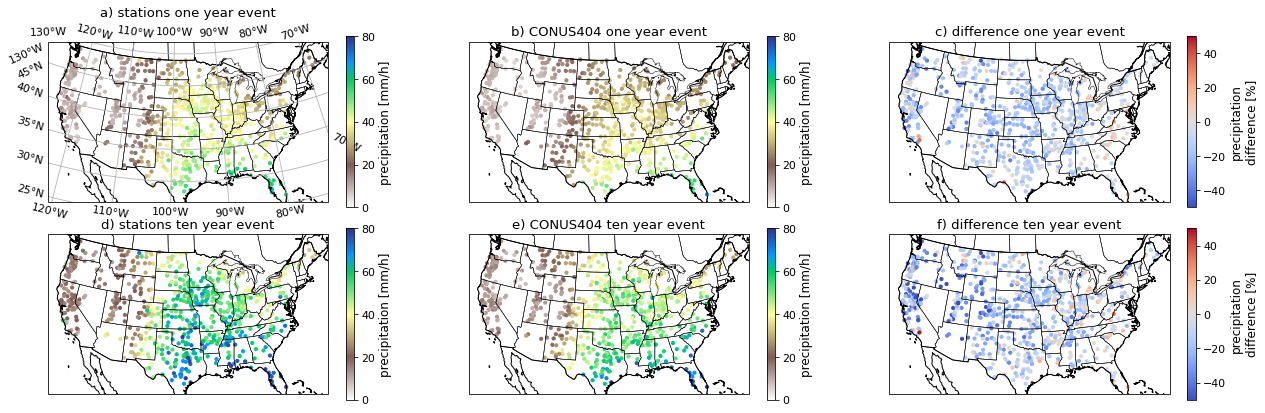

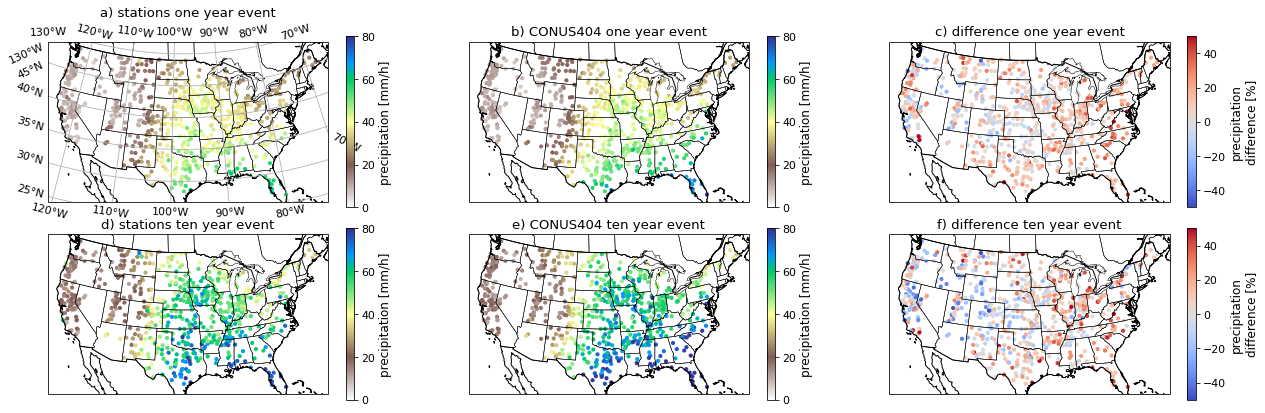

In [14]:
# We plot this image 2-times. Once with the original data and a second time by
# applying an areal reduction factor to the model data that comes from Fig. 4 in
# https://www.mdpi.com/2073-4441/11/6/1120

Stats = ['original','ARF']

for st in range(len(Stats)):
    fig = plt.figure(figsize=(18,6))
    rgsLableABC=list(string.ascii_lowercase)
    plt.rcParams.update({'font.size': 11})
    gs1 = gridspec.GridSpec(2,3)
    gs1.update(left=0.05, right=0.97,
               bottom=0.05, top=0.9,
               wspace=0.2, hspace=0.1)

    #plot blue ocean and lakes
    clevs=0
    GEO_EM_D1 = '/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'
    ncfile = Dataset(GEO_EM_D1)
    HGT_M = getvar(ncfile, "HGT_M")
    cart_proj = get_cartopy(HGT_M)
    ncid.close()

    RPs = ['one year event', 'ten year event']
    DATA = ['stations', 'CONUS404','difference']
    for rp in range(len(RPs)):
        if RPs[rp] == 'one year event':
            DATAact = np.copy(OneYevent)
        elif RPs[rp] == 'ten year event':
            DATAact = np.copy(TenYevent)
        
        if st == 1:
            DATAact[:,1] = DATAact[:,1]*1.25

        for da in range(3):
            ax = plt.subplot(gs1[rp,da], projection=cart_proj)
            # Add COOP station locations
            if da < 2:
                cs = plt.scatter(LonAll, LatAll, c=DATAact[:,da], cmap='terrain_r', vmin=0, vmax=80, transform=ccrs.PlateCarree(),s=10)
                CP_legend = 'precipitation [mm/h]'
            else:
                Diff = ((DATAact[:,1]-DATAact[:,0])/DATAact[:,0])*100
                cs = plt.scatter(LonAll, LatAll, c=Diff, cmap='coolwarm', vmin=-50, vmax=50, transform=ccrs.PlateCarree(),s=10)
                CP_legend = 'precipitation\ndifference [%]'

            # # Add a color bar
            # cb = plt.colorbar(cs, ax=ax, shrink=.98)
            # cb.set_label('Orography [m]', fontsize=12)

            ax.coastlines()
            ax.add_feature(cf.BORDERS)
            ax.add_feature(cf.STATES, lw=0.5)

            if (da == 0) & (rp ==0):
                gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
                gl.right_labels = False

            # Add a color bar
            cb = plt.colorbar(cs, ax=ax, shrink=.98)
            cb.set_label(CP_legend, fontsize=12)
            plt.title(rgsLableABC[da+rp*3]+') '+DATA[da]+' '+RPs[rp])


    sPlotFile=sPlotDir
    sPlotName= 'Horly-Rerturen-Level-events_'+Stats[st]+'.pdf'
    if os.path.isdir(sPlotFile) != 1:
        subprocess.call(["mkdir","-p",sPlotFile])
    print( '        Plot map to: '+sPlotFile+sPlotName)
    fig.savefig(sPlotFile+sPlotName) #, dpi=700)


### Get stations for each subregion

In [15]:
rgiStatsInBasins = []
MaskStations = np.zeros((len(LonSTCO))); MaskStations[:] = np.nan
rgrGridCells=[(LonSTCO.ravel()[ii],LatSTCO.ravel()[ii]) for ii in range(len(LonSTCO.ravel()))]
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        ctr=TEST.T
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
    iStationSelect = np.where(TMP == 1)[0]
    rgiStatsInBasins = np.append(rgiStatsInBasins,iStationSelect)
    MaskStations[TMP==1] = re+1
#     MaskStations = np.append(MaskStations,[re+1]*len(iStationSelect))
rgiStatsInBasins = rgiStatsInBasins.astype('int')
MaskStations = MaskStations.astype('int')

### Calculate Precipitation PDFs for each region

In [16]:
import warnings
warnings.filterwarnings('ignore')
Percentiles = np.arange(0,200,2.5)
PercentilesC = (Percentiles[1:]+Percentiles[:-1])/2
MASK = MaskStations[iSelect]

PDF_regions = np.zeros((len(REGIONS),len(Percentiles)-1,3)); PDF_regions[:] = np.nan
for re in tqdm(range(len(REGIONS))):
    iStats = MASK == (re+1)
    NAN = ((~np.isnan(DATA_all[:,iStats,0]) == True) & \
           (~np.isnan(DATA_all[:,iStats,1]) == True) & \
           (~np.isnan(DATA_all[:,iStats,2]) == True)).flatten()
    for da in range(3):
        Data_act = np.copy(np.array(DATA_all[:,iStats,da].flatten()))
        Data_act = Data_act[NAN == True]
        for pp in range(len(Percentiles)-1):
            PDF_regions[re,pp,da] = np.sum((Data_act>=Percentiles[pp]) & (Data_act<Percentiles[pp+1]))


100%|██████████| 17/17 [00:53<00:00,  3.12s/it]


### Plot hourly PR-PDFs per region

In [17]:
PDF_norm = PDF_regions/np.nansum(PDF_regions, axis=1)[:,None,:]

        Plot map to: Horly-Precipitation-PDFs_Regions.pdf


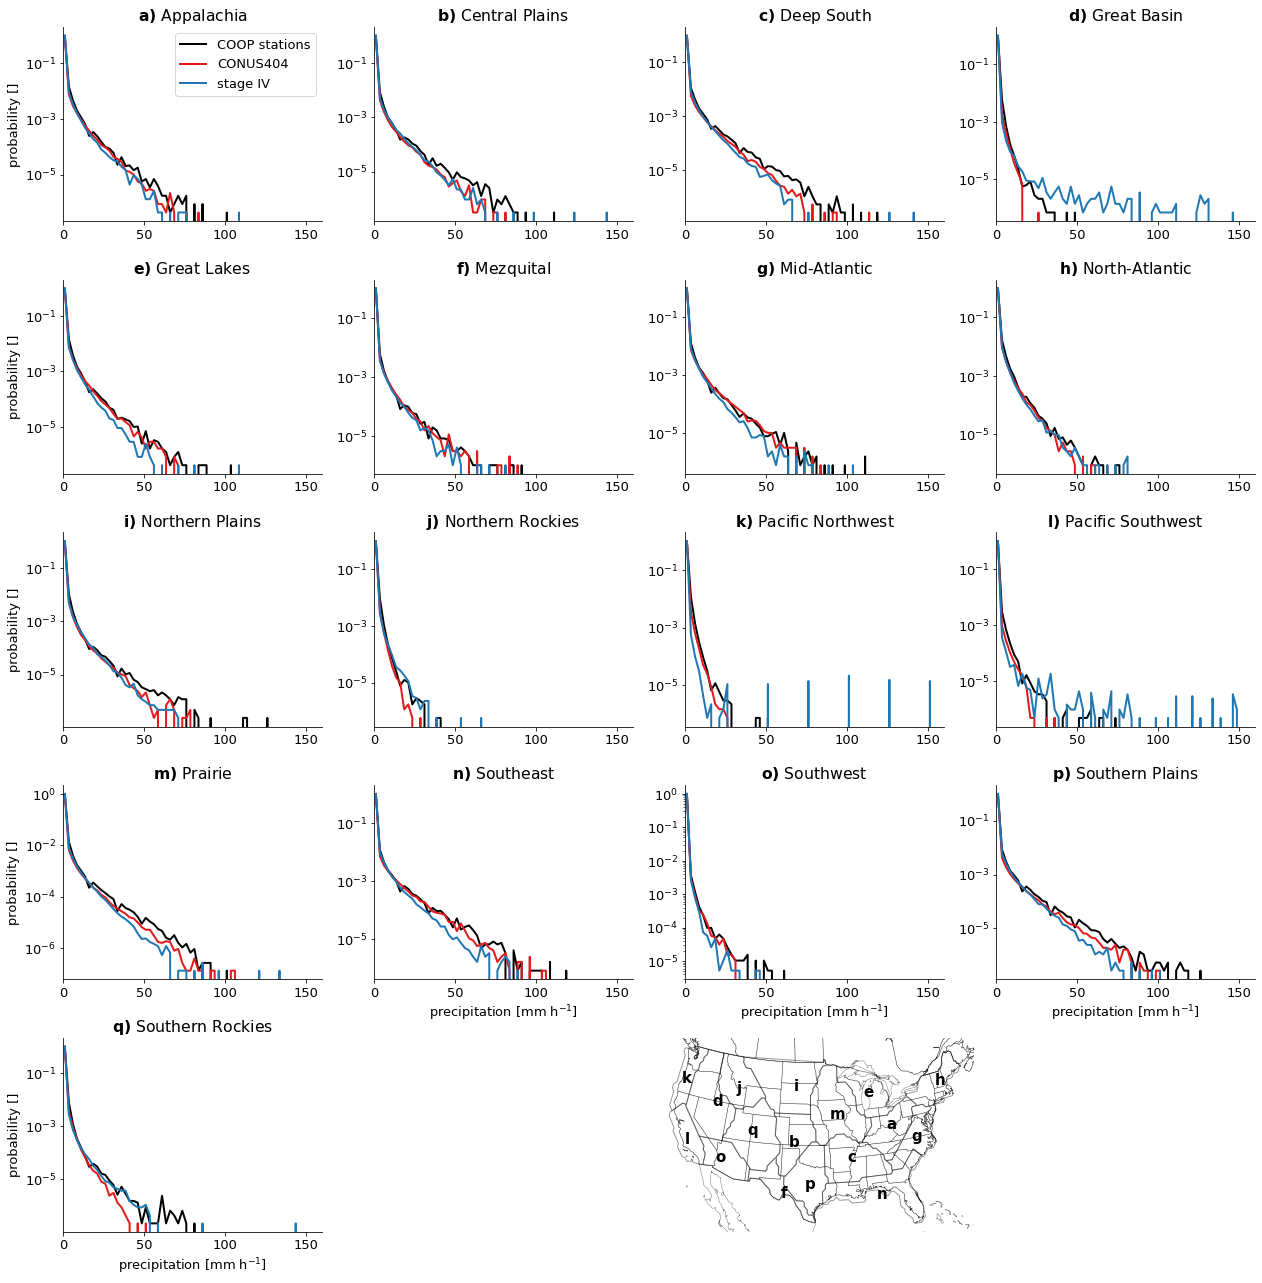

In [18]:
fig = plt.figure(figsize=(18,18))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(5,4)
gs1.update(left=0.05, right=0.97,
           bottom=0.05, top=0.98,
           wspace=0.20, hspace=0.30)

XX = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
YY = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
for re in range(len(REGIONS_names)):
    ax = plt.subplot(gs1[YY[re],XX[re]])
    
    plt.plot(PercentilesC,PDF_norm[re,:,0], c='k', lw=2, label='COOP stations')
    plt.plot(PercentilesC,PDF_norm[re,:,1], c='#e31a1c', lw=2, label='CONUS404')
    plt.plot(PercentilesC,PDF_norm[re,:,2], c='#1f78b4', lw=2, label='stage IV')
    ax.set_yscale('log')
    plt.xlim(0,160)
    
    if XX[re] == 0:
        ax.set_ylabel('probability []')
    if (YY[re] == 4) | ((YY[re] == 3) & (XX[re] > 0)):
        ax.set_xlabel('precipitation [mm h$^{-1}$]')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if re == 0:
        plt.legend()
    
    plt.title(r"$\bf{" + rgsLableABC[re] + ")}$ "+REGIONS_names[re])
    
# -----------------------
# plot an overview map showing the region locaations
ax = plt.subplot(gs1[4,1:4], projection=cart_proj)
import geopandas as gpd
ncfile = Dataset('/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc')
HGT_M = getvar(ncfile, "HGT_M")
cart_proj = get_cartopy(HGT_M)
ncid.close()
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)
        # label the region
        XX = np.mean(TEST[:,0])
        YY = np.mean(TEST[:,1])

        plt.text(XX,YY, r"$\bf{" + rgsLableABC[re] + "}$", transform=ccrs.PlateCarree(), color='k', fontsize=15, ha='center',va='center')
plt.axis('off')
ax.coastlines(lw=0.5, alpha=0.5)
ax.add_feature(cf.BORDERS, lw=0.5, alpha=0.5)
ax.add_feature(cf.STATES, lw=0.5, alpha=0.5)

sPlotFile=sPlotDir
sPlotName= 'Horly-Precipitation-PDFs_Regions.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName) #, dpi=700)

### Calculate Quantile-Quantile Plots for each region

In [19]:
# # this works well for contineous data
# NN = 200
# XX = np.linspace(1, 10.0, num=NN)**2
# XX = np.abs(XX-100)[::-1]+1
# XX[0] = 0
# XX_center = (XX[1:]+XX[:-1])/2
# print(XX)

# XX = [[0,0.0001],
#      [0.0001,bucked_size*1.01],
#      [bucked_size*1.01,bucked_size*1.01*3],
#      [bucked_size*1.01*3,'99.75'],
#      ['99.5','100']]

BinNames = ['dry','light','mod.','heavy','extreme']
BINS = [[0,0.0001],
     [0.0001,bucked_size*1.01],
     [bucked_size*1.01,'99.95'],
     ['99.95','99.98'],
     ['99.98','100']]

### Coarsen datasets to observed bucked size

In [20]:
rgrCoarsened_PR = np.copy((DATA_all)); rgrCoarsened_PR[:] = np.nan
for da in [0,1]:
    Data_act = np.copy(DATA_all[:,:,da])
    rgrCoarsened_PR[:,:,da] = deiscretice_timeseries(Data_act,
                                    bucked_size)

100%|██████████| 176640/176640 [00:13<00:00, 13054.87it/s]


### Calculate annual frequency in bins at station level

In [21]:
YEARS = np.unique(TimeHH.year)[1:]
bin_freq_stations = np.zeros((len(YEARS), DATA_all.shape[1],len(BINS),2)); bin_freq_stations[:] = np.nan
# for st in tqdm(range(DATA_all.shape[1])):
for da in [0,1]:
    Data_act = np.copy(np.array(rgrCoarsened_PR[:,:,da]))
    for pp in tqdm(range(len(BINS))):
        if type(BINS[pp][0]) != str:
            pp_min = BINS[pp][0]
        else:
            pp_min = np.nanpercentile(Data_act, float(BINS[pp][0]), axis=0)
        if type(BINS[pp][1]) != str:
            pp_max = BINS[pp][1]
        else:
            pp_max = np.nanpercentile(Data_act, float(BINS[pp][1]), axis=0)
        for yy in range(len(YEARS)):
            tt_focus = (TimeHH.year == YEARS[yy])
            Data_act_yy = Data_act[tt_focus,:]
            NAN = ((np.isnan(rgrCoarsened_PR[tt_focus,:,0]) == True) | \
                   (np.isnan(rgrCoarsened_PR[tt_focus,:,1]) == True))
            Data_act_yy[NAN == True] = 99999999.
            Avail_data_ratio = np.sum(Data_act_yy < 99999, axis=0) / np.sum(tt_focus)
            Bin_frequency = np.array(np.sum((Data_act_yy >= pp_min) & (Data_act_yy < pp_max), axis=0)).astype('float')
            Bin_frequency[Avail_data_ratio < 0.8] = np.nan
            bin_freq_stations[yy,:,pp,da] = Bin_frequency * 1./Avail_data_ratio

100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


In [22]:
np.nanmean(bin_freq_stations[:,:,4,:], axis=(0,1))

array([1.24592127, 1.2886144 ])

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
# calculate trends in the bin frequency
Stats = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
frequ_tends_yyyy = np.zeros((DATA_all.shape[1],len(BINS),2,len(Stats))); frequ_tends_yyyy[:] = np.nan
for st in tqdm(range(DATA_all.shape[1])):
    for da in [0,1]:
        for pp in range(len(BINS)):
            data_act = bin_freq_stations[2:-1,st,pp,da]
            FIN = ~np.isnan(data_act)
            frequ_tends_yyyy[st,pp,da,:] = stats.linregress(YEARS[2:-1][FIN], data_act[FIN])
            frequ_tends_yyyy[st,pp,da,0] = (frequ_tends_yyyy[st,pp,da,0]/np.mean(data_act[FIN])) * 100

100%|██████████| 684/684 [00:01<00:00, 350.50it/s]


### Plot linear trend estimate on map

        Plot map to: Trends-in-PR-frequency.pdf


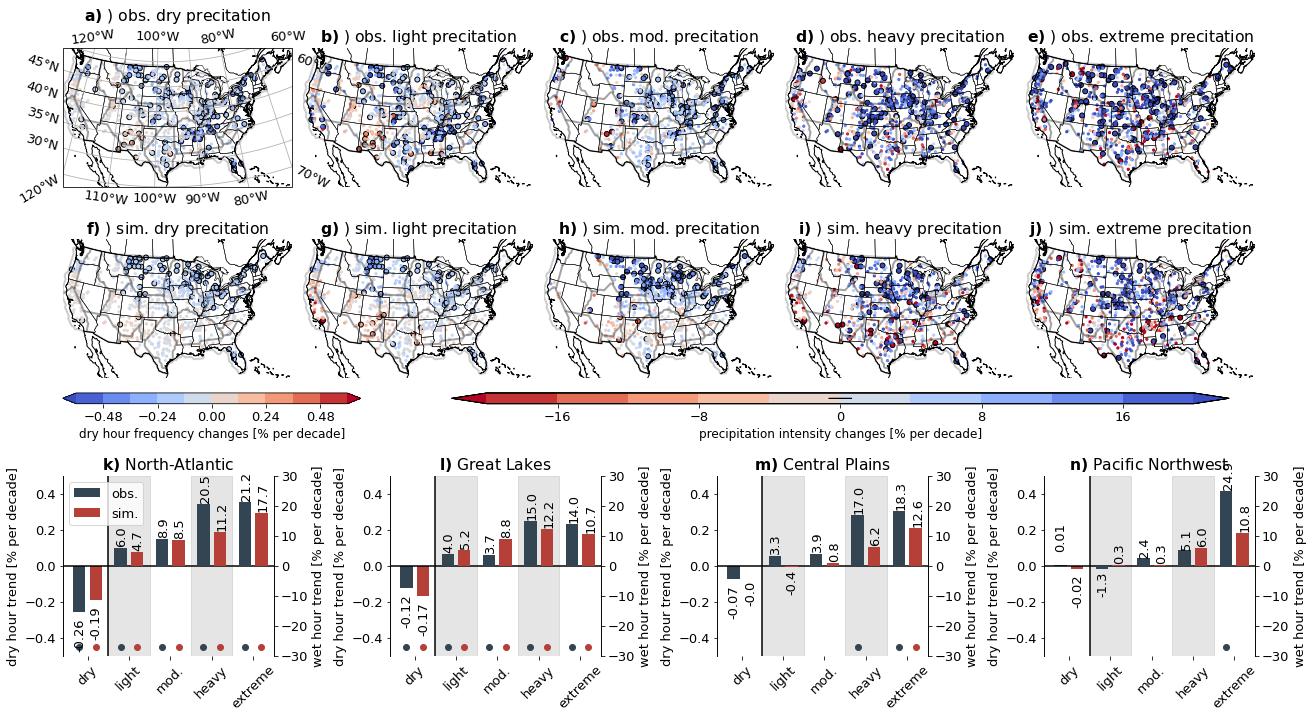

In [25]:
fig = plt.figure(figsize=(18,10))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(2,len(BinNames))
gs1.update(left=0.05, right=0.97,
           bottom=0.43, top=0.9,
           wspace=0.05, hspace=0.3)


DATA = ['obs.', 'sim.']
Colorbar_range = [[-0.6,0.6],[-20,20],[-20,20],[-20,20],[-20,20]]
CMAP = ['coolwarm','coolwarm_r','coolwarm_r','coolwarm_r','coolwarm_r']

for da in range(2):
    for pp in range(len(BINS)):
        ax = plt.subplot(gs1[da,pp], projection=cart_proj)
        # Add COOP station locations
        Sig = frequ_tends_yyyy[:,pp,da,3] <= 0.1
        plt.scatter(LonAll[Sig], LatAll[Sig], c=frequ_tends_yyyy[Sig,pp,da,0]*10, cmap=CMAP[pp], 
                         vmin=Colorbar_range[pp][0], vmax=Colorbar_range[pp][1], transform=ccrs.PlateCarree(), s=25 ,edgecolors='k')
        cs = ax.contourf([[0,0],[0,0]],[[0,0],[0,0]], cmap=CMAP[pp], levels=np.linspace(Colorbar_range[pp][0],Colorbar_range[pp][1],11), extend='both')
        NotSig = frequ_tends_yyyy[:,pp,da,3] > 0.1
        plt.scatter(LonAll[NotSig], LatAll[NotSig], c=frequ_tends_yyyy[NotSig,pp,da,0]*10, cmap=CMAP[pp], 
                         vmin=Colorbar_range[pp][0], vmax=Colorbar_range[pp][1], transform=ccrs.PlateCarree(), s=5)
        CP_legend = 'wet hour frequency [%]'

        ax.coastlines()
        ax.add_feature(cf.BORDERS)
        ax.add_feature(cf.STATES, lw=0.5)
        plt.title(r"$\bf{" + rgsLableABC[da*5+pp] + ")}$ "+') '+DATA[da]+' '+BinNames[pp]+' precitation')
        
        ax.set_extent((-120, -70, 50, 25), ccrs.PlateCarree())

        if (da == 0) & (pp == 0):
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.right_labels = False
        else:
            plt.axis('off')

        # plot the subregions
        for re in range(len(REGIONS)):
            data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
            Coordinates = data['geometry']
            for sf in range(len(data)):
                TEST = np.array(Coordinates[sf].exterior.coords.xy)
                TEST=TEST.T
                plt.plot(TEST[:,0],TEST[:,1], lw=2, c='k', transform=ccrs.PlateCarree(), alpha=0.2)

        if (da == 0) & (pp == 0):
            # Add a color bar
            CbarAx = axes([0.05, 0.4, 0.23, 0.015])
            cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max')#, ticks=np.linspace(0,0.0015,41))
            # cb.ax.set_xticklabels(LEVS,rotation=90)
            cb.set_label('dry hour frequency changes [% per decade]', fontsize=12)     
        if (da == 0) & (pp >= 0):
            # Add a color bar
            CbarAx = axes([0.35, 0.4, 0.6, 0.015])
            cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max')#, ticks=np.linspace(0,0.0015,41))
            # cb.ax.set_xticklabels(LEVS,rotation=90)
            cb.set_label('precipitation intensity changes [% per decade]', fontsize=12)  

            
### Add regional statistics in bottom row
gs1 = gridspec.GridSpec(1,4)
gs1.update(left=0.05, right=0.97,
           bottom=0.05, top=0.30,
           wspace=0.55, hspace=0.30)

SelReg = [7,4,1,10]
for re in range(len(SelReg)):
    ax = plt.subplot(gs1[0,re])
    iStats = MASK == (SelReg[re]+1)
    trends = np.zeros((bin_freq_stations.shape[2], bin_freq_stations.shape[3], len(Stats))); trends[:] = np.nan
    for da in range(bin_freq_stations.shape[3]):
        for pp in range(bin_freq_stations.shape[2]):
            data_act = np.nanmean(bin_freq_stations[2:-1,iStats,pp,da], axis=1)
            FIN_all = ~np.isnan(data_act)
            trends[pp,da,:] = stats.linregress(YEARS[2:-1][FIN], data_act[FIN])
            trends[pp,da,0] = (trends[pp,da,0]/np.mean(data_act[FIN])) * 100
    
    plt.bar(0.4, trends[0,0,0]*10., width=0.3, color='#334553', label='obs.')
    plt.bar(0.8, trends[0,1,0]*10., width=0.3, color='#b44038', label='sim.')
    plt.plot()
    plt.axvline(x=1.1, c='k')
    plt.axhline(y=0, c='k')
    plt.ylim(-0.5,0.5)
    if re == 0:
        plt.legend(loc = 'upper left')

    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.xticks([0.6, 1.6, 2.6, 3.6, 4.6], BinNames)
    plt.xticks(rotation=45)

    ax1 = ax.twinx()
    for pp in range(bin_freq_stations.shape[2]-1):
        plots = plt.bar(1.4+pp, trends[pp+1,0,0]*10., width=0.3, color='#334553')
        plots = plt.bar(1.8+pp, trends[pp+1,1,0]*10., width=0.3, color='#b44038')
    plt.ylim(-30,30)
    plt.xlim(0,5.1)

    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(str(np.round(p.get_height(),2)), (p.get_x() * 1.01, p.get_height() + 0.09), rotation=90)
        else:
            ax.annotate(str(np.round(p.get_height(),2)), (p.get_x() * 1.01, p.get_height() -0.2), rotation=90)
    for p in ax1.patches:
        if p.get_height() > 0:
            ax1.annotate(str(np.round(p.get_height(),1)), (p.get_x() * 1.01, p.get_height() + 1.5), rotation=90)
        else:
            ax1.annotate(str(np.round(p.get_height(),1)), (p.get_x() * 1.01, p.get_height() -8), rotation=90)
            
    # plot significacne information
    colors = ['#334553','#b44038']
    for pp in range(bin_freq_stations.shape[2]):
        for da in range(2):
            if trends[pp,da,3] <= 0.1:
                ax.plot(0.4+0.4*da + pp, -0.45, color=colors[da], marker = 'o')
    
    ax.axvspan(1.1, 2.1, alpha=0.1, color='k')
    ax.axvspan(3.1, 4.1, alpha=0.1, color='k')

    ax.set_ylabel('dry hour trend [% per decade]')
    ax1.set_ylabel('wet hour trend [% per decade]')

    ax1.spines['bottom'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    


    
    plt.title(r"$\bf{" + rgsLableABC[re+10] + ")}$ "+REGIONS_names[SelReg[re]])
            
sPlotFile=sPlotDir
sPlotName= 'Trends-in-PR-frequency.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

### Show average changes in subregions

        Plot map to: Horly-Precipitation-PDFs_Changes.pdf


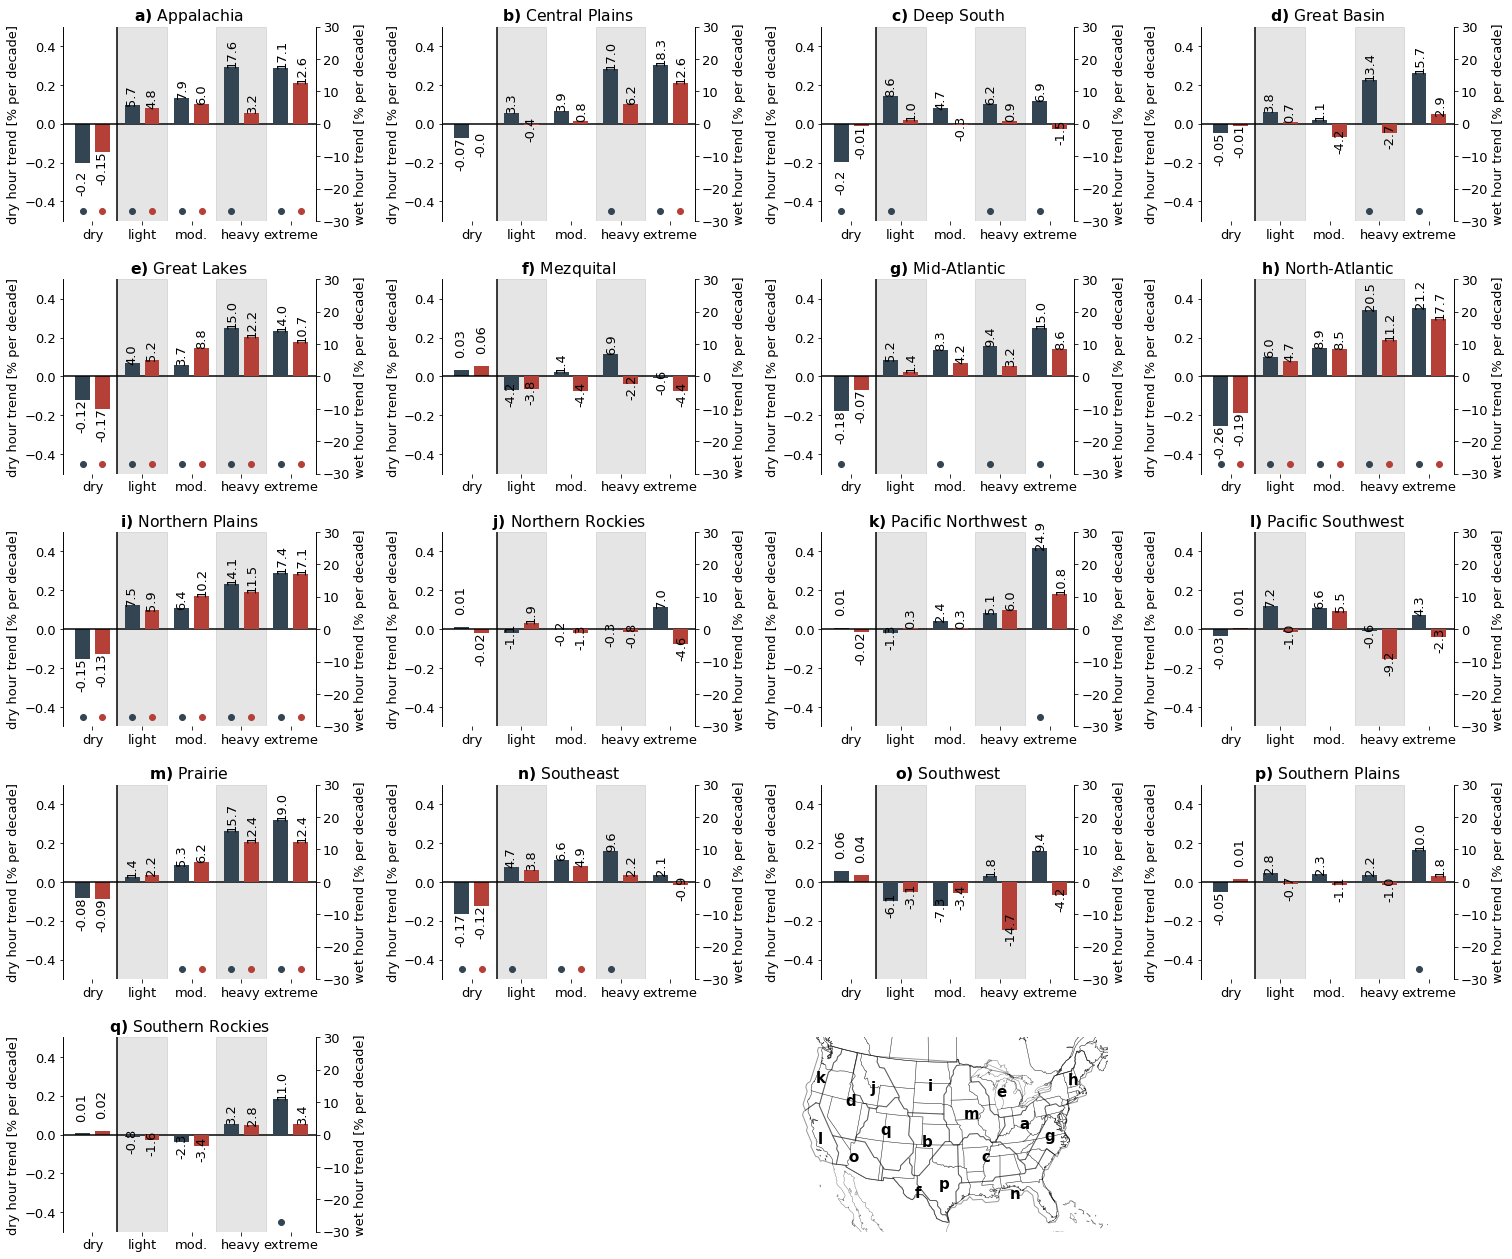

In [26]:
from matplotlib.collections import LineCollection


fig = plt.figure(figsize=(21,18))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(5,4)
gs1.update(left=0.05, right=0.97,
           bottom=0.05, top=0.98,
           wspace=0.5, hspace=0.30)

XX = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
YY = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
for re in range(len(REGIONS_names)):
    ax = plt.subplot(gs1[YY[re],XX[re]])
    iStats = MASK == (re+1)
    trends = np.zeros((bin_freq_stations.shape[2], bin_freq_stations.shape[3], len(Stats))); trends[:] = np.nan
    for da in range(bin_freq_stations.shape[3]):
        for pp in range(bin_freq_stations.shape[2]):
            data_act = np.nanmean(bin_freq_stations[2:-1,iStats,pp,da], axis=1)
            FIN_all = ~np.isnan(data_act)
            trends[pp,da,:] = stats.linregress(YEARS[2:-1][FIN], data_act[FIN])
            trends[pp,da,0] = (trends[pp,da,0]/np.mean(data_act[FIN])) * 100
    
    plt.bar(0.4, trends[0,0,0]*10., width=0.3, color='#334553')
    plt.bar(0.8, trends[0,1,0]*10., width=0.3, color='#b44038')
    plt.plot()
    plt.axvline(x=1.1, c='k')
    plt.axhline(y=0, c='k')
    plt.ylim(-0.5,0.5)

    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax1 = ax.twinx()
    for pp in range(bin_freq_stations.shape[2]-1):
        plots = plt.bar(1.4+pp, trends[pp+1,0,0]*10., width=0.3, color='#334553')
        plots = plt.bar(1.8+pp, trends[pp+1,1,0]*10., width=0.3, color='#b44038')
    plt.ylim(-30,30)
    plt.xlim(0,5.1)

    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(str(np.round(p.get_height(),2)), (p.get_x() * 1.01, p.get_height() + 0.08), rotation=90)
        else:
            ax.annotate(str(np.round(p.get_height(),2)), (p.get_x() * 1.01, p.get_height() -0.15), rotation=90)
    for p in ax1.patches:
        if p.get_height() > 0:
            ax1.annotate(str(np.round(p.get_height(),1)), (p.get_x() * 1.01, p.get_height() + 0.8), rotation=90)
        else:
            ax1.annotate(str(np.round(p.get_height(),1)), (p.get_x() * 1.01, p.get_height() -4), rotation=90)
            
    # plot significacne information
    colors = ['#334553','#b44038']
    for pp in range(bin_freq_stations.shape[2]):
        for da in range(2):
            if trends[pp,da,3] <= 0.1:
                ax.plot(0.4+0.4*da + pp, -0.45, color=colors[da], marker = 'o')
    
    ax.axvspan(1.1, 2.1, alpha=0.1, color='k')
    ax.axvspan(3.1, 4.1, alpha=0.1, color='k')

    ax.set_ylabel('dry hour trend [% per decade]')
    ax1.set_ylabel('wet hour trend [% per decade]')

    ax1.spines['bottom'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    plt.xticks([0.6, 1.6, 2.6, 3.6, 4.6], BinNames)
    plt.xticks(rotation = 45)

    
    plt.title(r"$\bf{" + rgsLableABC[re] + ")}$ "+REGIONS_names[re])
    
# -----------------------
# plot an overview map showing the region locaations
ax = plt.subplot(gs1[4,1:4], projection=cart_proj)
import geopandas as gpd
ncfile = Dataset('/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc')
HGT_M = getvar(ncfile, "HGT_M")
cart_proj = get_cartopy(HGT_M)
ncid.close()
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)
        # label the region
        XX = np.mean(TEST[:,0])
        YY = np.mean(TEST[:,1])

        plt.text(XX,YY, r"$\bf{" + rgsLableABC[re] + "}$", transform=ccrs.PlateCarree(), color='k', fontsize=15, ha='center',va='center')
plt.axis('off')
ax.coastlines(lw=0.5, alpha=0.5)
ax.add_feature(cf.BORDERS, lw=0.5, alpha=0.5)
ax.add_feature(cf.STATES, lw=0.5, alpha=0.5)


sPlotFile=sPlotDir
sPlotName= 'Horly-Precipitation-PDFs_Changes.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

### Plot the frequency of wet hours

In [27]:
# calculate percentile where hourly precip is > 0
wet_perc = np.zeros((DATA_all.shape[1],2))
for da in range(2):
    for st in range(DATA_all.shape[1]):
        wet_perc[st,da] = np.sum(rgrCoarsened_PR[:,st,da] > 0)/np.sum(rgrCoarsened_PR[:,st,da] >= 0)

        Plot map to: Frequ-dry-hours.pdf


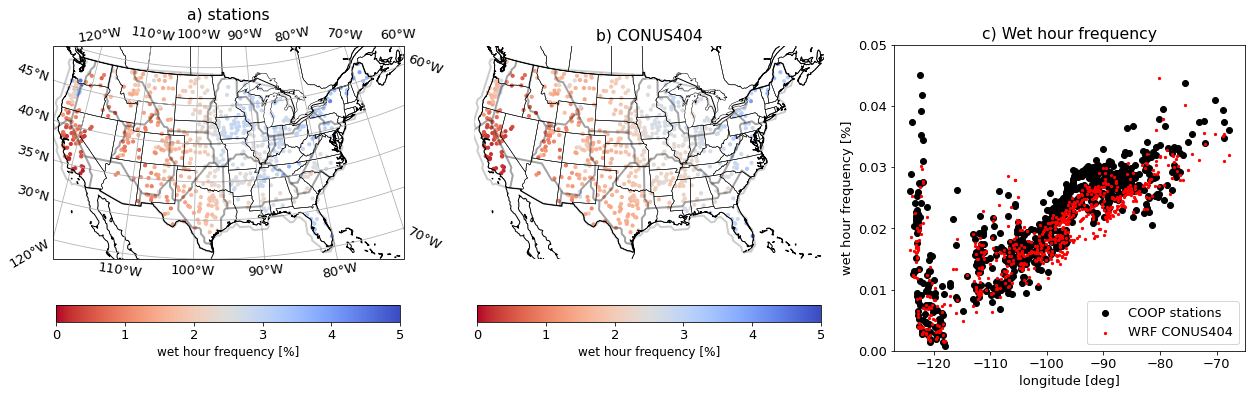

In [31]:
fig = plt.figure(figsize=(18,5))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.05, right=0.97,
           bottom=0.05, top=0.9,
           wspace=0.2, hspace=0.1)

#plot blue ocean and lakes
clevs=0
GEO_EM_D1 = '/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT_M")
cart_proj = get_cartopy(HGT_M)
ncid.close()

DATA = ['stations', 'CONUS404']

for da in range(2):
    ax = plt.subplot(gs1[0,da], projection=cart_proj)
    # Add COOP station locations
    cs = plt.scatter(LonAll, LatAll, c=wet_perc[:,da]*100, cmap='coolwarm_r', vmin=0, vmax=5, transform=ccrs.PlateCarree(),s=10)
    CP_legend = 'wet hour frequency [%]'
    

    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES, lw=0.5)
    ax.set_extent((-120, -70, 50, 25), ccrs.PlateCarree())
    plt.title(rgsLableABC[da]+') '+DATA[da])
    
    # plot the subregions
    for re in range(len(REGIONS)):
        data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
        Coordinates = data['geometry']
        for sf in range(len(data)):
            TEST = np.array(Coordinates[sf].exterior.coords.xy)
            TEST=TEST.T
            plt.plot(TEST[:,0],TEST[:,1], lw=2, c='k', transform=ccrs.PlateCarree(), alpha=0.2)
    
    if (da == 0):
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.right_labels = False

        # Add a color bar
        CbarAx = axes([0.05, 0.05, 0.55, 0.03])
#         cb = plt.colorbar(cs, ax = CbarAx, orientation='horizontal', extend='both')
#         cb.set_label(CP_legend, fontsize=12) #, fontsize=12)
    else:
        plt.axis('off')
        
    cb = plt.colorbar(cs, ax=ax, shrink=.98, orientation='horizontal')
    cb.set_label(CP_legend, fontsize=12)


ax = plt.subplot(gs1[0,2])
plt.scatter(LonAll, wet_perc[:,0], c='k', label='COOP stations')
plt.scatter(LonAll, wet_perc[:,1], c='r', s=5, label='WRF CONUS404')
plt.ylim(0,0.05)
plt.title(rgsLableABC[2]+') Wet hour frequency')
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('wet hour frequency [%]')
plt.legend()


sPlotFile=sPlotDir
sPlotName= 'Frequ-dry-hours.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

### Changes in fractional precipitation contribution

In [29]:
bins_unique = np.unique(rgrCoarsened_PR[:,:,0])
bins_unique = bins_unique[~np.isnan(bins_unique)]

In [30]:
# Calculate fractional contribution of precipitation
bootstratp_nr = 100
pr_frac_contributions = np.zeros((len(bins_unique), 2, bootstratp_nr, len(REGIONS))); pr_frac_contributions[:] = np.nan
import random
half_rec_len = int(rgrCoarsened_PR.shape[0]/2)
SampleSize = 50000

for re in range(len(REGIONS)):
    print('work on '+REGIONS[re])
    iStats = MASK == (re+1)
    for bs in tqdm(range(bootstratp_nr)):
        for pe in range(2):
            if pe == 0:
                sample = random.sample(range(0, half_rec_len), SampleSize)
            elif pe == 1:
                sample = random.sample(range(half_rec_len, rgrCoarsened_PR.shape[0]-1), SampleSize)
            
            DATA_test = rgrCoarsened_PR[sample,:,0][:,iStats].flatten()
            pr_frac_contributions[:,pe,bs,re] = np.array([np.sum(DATA_test[(DATA_test == bins_unique[ii])]) 
                                                          for ii in range(len(bins_unique))])


  0%|          | 0/100 [00:00<?, ?it/s]

work on Appalachia.shp


  0%|          | 0/100 [00:00<?, ?it/s]

work on CPlains.shp


  0%|          | 0/100 [00:00<?, ?it/s]

work on DeepSouth.shp


  0%|          | 0/100 [00:00<?, ?it/s]

work on GreatBasin.shp


  0%|          | 0/100 [00:00<?, ?it/s]

work on GreatLakes.shp


 64%|██████▍   | 64/100 [01:41<00:56,  1.58s/it]


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(18,18))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(5,4)
gs1.update(left=0.05, right=0.97,
           bottom=0.05, top=0.98,
           wspace=0.20, hspace=0.30)

x_vals = np.copy(bins_unique)
x_vals_width = np.append(0, x_vals[1:]-x_vals[:-1])
x_vals[0] = 1

mo = 1

XX = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
YY = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
for re in range(len(REGIONS_names)):
    ax = plt.subplot(gs1[YY[re],XX[re]])
    
    print('work on '+REGIONS[re])
    Contribution = np.median(pr_frac_contributions[:,0,:,re]*x_vals_width[:,None]/np.sum(pr_frac_contributions[:,0,:,re]*x_vals_width[:,None], axis=0), axis=1)
    cont_spread = np.percentile(pr_frac_contributions[:,0,:,re]*x_vals_width[:,None]/np.sum(pr_frac_contributions[:,0,:,re]*x_vals_width[:,None], axis=0), (25,75),  axis=1)
#     cont_spread = cont_spread*x_vals_width[None,:]/np.sum(cont_spread*x_vals_width[None,:], axis=1)[:,None]
    plt.plot(x_vals, Contribution, c='k', label = '1980-1999')
    plt.fill_between(x_vals, cont_spread[0,:], y2=cont_spread[1,:], color='k', alpha=0.2)

    Contribution1 = np.median(pr_frac_contributions[:,1,:,re]*x_vals_width[:,None]/np.sum(pr_frac_contributions[:,1,:,re]*x_vals_width[:,None], axis=0), axis=1)
    cont_spread1 = np.percentile(pr_frac_contributions[:,1,:,re]*x_vals_width[:,None]/np.sum(pr_frac_contributions[:,1,:,re]*x_vals_width[:,None], axis=0), (25,75),  axis=1)
    # cont_spread1 = cont_spread1*x_vals_width/np.sum(cont_spread1*x_vals_width, axis=1)[:,None]
    plt.plot(x_vals, Contribution1, c='r', label = '2000-2020')
    plt.fill_between(x_vals, cont_spread1[0,:], y2=cont_spread1[1,:], color='r', alpha=0.2)
    
    diff_all = (pr_frac_contributions[:,1,:,re]*x_vals_width[:,None]/np.sum(pr_frac_contributions[:,1,:,re]*x_vals_width[:,None], axis=0))-\
            (pr_frac_contributions[:,0,:,re]*x_vals_width[:,None]/np.sum(pr_frac_contributions[:,0,:,re]*x_vals_width[:,None], axis=0))
    plt.plot(x_vals, np.median(diff_all, axis=1), c='b', label = 'difference')
    
    plt.fill_between(x_vals, np.percentile(diff_all, 75, axis=1), y2=np.percentile(diff_all, 25, axis=1), color='b', alpha=0.2)
    ax.set_xscale('log')

    plt.axhline(y=0, color='k', linestyle='-', lw=0.75)
    if XX[re] == 0:
        ax.set_ylabel('fractional contribution []')
    if (YY[re] == 4) | ((YY[re] == 3) & (XX[re] > 0)):
        ax.set_xlabel('precipitation [mm h$^{-1}$]')
        
    if re == 0:
        plt.legend()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xlim((1,120))
#     plt.ylim((-12,8))
    
    plt.title(r"$\bf{" + rgsLableABC[re] + ")}$ "+REGIONS_names[re])
    
# # -----------------------
# # plot an overview map showing the region locaations
# import geopandas as gpd
# ncfile = Dataset('/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc')
# HGT_M = getvar(ncfile, "HGT_M")
# cart_proj = get_cartopy(HGT_M)
# ncid.close()
# ax = plt.subplot(gs1[4,1:4], projection=cart_proj)
# for re in range(len(REGIONS)):
#     data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
#     Coordinates = data['geometry']
#     for sf in range(len(data)):
#         TEST = np.array(Coordinates[sf].exterior.coords.xy)
#         TEST=TEST.T
#         plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)
#         # label the region
#         XX = np.mean(TEST[:,0])
#         YY = np.mean(TEST[:,1])
#         plt.text(XX,YY, r"$\bf{" + rgsLableABC[re] + "}$", transform=ccrs.PlateCarree(), color='k', fontsize=15, ha='center',va='center')
        
# plt.axis('off')
# ax.coastlines(lw=0.5, alpha=0.5)
# ax.add_feature(cf.BORDERS, lw=0.5, alpha=0.5)
# ax.add_feature(cf.STATES, lw=0.5, alpha=0.5)

sPlotFile=sPlotDir
sPlotName= 'Fractional-Contribution-Changes_COOP.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName) #, dpi=700)

### Fractional contribution to precipitation

In [ ]:
NN = 100
bins = np.array([0]+ [np.exp(np.log(0.005) + (ii* ((np.log(120)-np.log(0.005))**2/(NN)) )**0.5 ) for ii in range(NN)])
bins_cent = (bins[1:]+bins[:-1])/2
# bins = np.exp(np.linspace(0,4.5,101))-1

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

re = 14

# DATA_test = DATA_all[:170000, :,2].flatten()
# Contribution = np.array([np.nansum(DATA_test[(DATA_test >= bins[ii]) & (DATA_test < bins[ii+1])]) for ii in range(len(bins)-1)])
# plt.plot(bins_cent, Contribution/np.nansum(Contribution), c='k')

DATA_test = DATA_all[-170000:, :,2].flatten()
Contribution1 = np.array([np.nansum(DATA_test[(DATA_test >= bins[ii]) & (DATA_test < bins[ii+1])]) for ii in range(len(bins)-1)])
plt.plot(bins_cent,Contribution1/np.nansum(Contribution1), c='r')

# plt.plot(bins_cent,Contribution1/np.nansum(Contribution1) - Contribution/np.sum(Contribution), c='b')
ax.set_xscale('log')

plt.xlim((0.1,100))

In [ ]:
np.nansum(DATA_test[DATA_test > 40])

### Trend in seasonality of heavy & extreme precipitation

In [ ]:
rgrCoarsened_PR.shape

In [ ]:
rgrCoarsened_PR.shape

In [ ]:
Quantile = 99.95
Events = int(DATA_all.shape[0] * (1-Quantile/100))
DayOfYear = np.zeros((Events, DATA_all.shape[1],2)); DayOfYear[:] = np.nan
YearOfExtreme = np.copy(DayOfYear)
# for st in tqdm(range(DATA_all.shape[1])):
for da in [0,1]:
    Data_act = np.copy(np.array(rgrCoarsened_PR[FocusHours,:,da]))
    Percentile = np.nanpercentile(Data_act, Quantile, axis=0)
    for st in tqdm(range(rgrCoarsened_PR.shape[1])):
        rgiExtremes = np.where(Data_act[:,st] >= Percentile[st])[0]
        ExtremeDates = TimeHH[rgiExtremes]
        DayOfYearAct = np.array([ExtremeDates[hh].timetuple().tm_yday for hh in range(len(ExtremeDates))])
        Year_of_extreme = np.array([ExtremeDates[hh].year for hh in range(len(ExtremeDates))])
        
        if Events != len(ExtremeDates):
            # randomly select the currect number of events
            RANDOM = np.array([int(np.random.uniform(0,len(ExtremeDates)-1)) for ex in range(Events)])
            DayOfYear[:,st,da] = DayOfYearAct[RANDOM]
            YearOfExtreme[:,st,da] = Year_of_extreme[RANDOM]
        else:
            DayOfYear[:,st,da] = DayOfYearAct
            YearOfExtreme[:,st,da] = Year_of_extreme

In [ ]:
re=0
da=0
iStats = MASK == (re+1)
year_overlap = 2
Years_sel = YEARS[1:-1]
Seasonality_stats = np.zeros((len(Years_sel), len(REGIONS_names),  5, 2))

for re in [re]: #range(len(REGIONS_names)):
    print(REGIONS_names[re])
    for da in range(2):
        iStats = MASK == (re+1)
        YYYY_Act = YearOfExtreme[:,iStats,da]
        DayOfYearAct = DayOfYear[:,iStats,da]
        for yy in range(Seasonality_stats.shape[0]):
            y_start = np.max([0,yy-year_overlap])
            y_stop = np.min([Seasonality_stats.shape[0]-1,yy+year_overlap])
            SelYY = (YYYY_Act >= Years_sel[y_start]) & (YYYY_Act <= Years_sel[y_stop])
            Seasonality_stats[yy, re, :, da] = np.percentile(DayOfYearAct[SelYY], (5,25,50,75,95))
            
    #     plt.plot(Years_sel, Seasonality_stats[:,0,0,da], c=colors[da], lw=0.5)
        plt.plot(Years_sel, Seasonality_stats[:,re,1,da], c=colors[da], lw=1)
        plt.plot(Years_sel, Seasonality_stats[:,re,2,da], c=colors[da], lw=2)
        plt.plot(Years_sel, Seasonality_stats[:,re,3,da], c=colors[da], lw=1)
    #     plt.plot(Years_sel, Seasonality_stats[:,0,4,da], c=colors[da], lw=0.5)

# plt.scatter(YearOfExtreme[:,iStats,da], DayOfYear[:,iStats,da])
# import seaborn as sns
# sns.kdeplot(x=YearOfExtreme[:,iStats,da].flatten(), y=DayOfYear[:,iStats,da].flatten(), cmap="Blues", shade=True, thresh=0)
# plt.show()